In [9]:
import time
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import Recall


In [2]:
#kernel test

## Load Radiology Reader Class
###### 100 GB of random access memory (RAM) required for training data

In [3]:
from src_tensorflow_keras import Rads_Reader

In [4]:
rr = Rads_Reader()

In [5]:
y = rr.y()

In [6]:
X = rr.X()

/home/ec2-user/SageMaker/x-ray-disease-classification/src_tensorflow_keras.py:60: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_half_selection = X[[training_df.index]]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

## Build CNN Model

In [8]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape = X_train[0].shape))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [47]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])


In [48]:
model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test))


Train on 4996 samples, validate on 556 samples
Epoch 1/15
4996/4996 [==============================] - 20s 4ms/sample - loss: 0.9103 - acc: 0.6051 - val_loss: 1.9384 - val_acc: 0.4874
Epoch 2/15
4996/4996 [==============================] - 17s 3ms/sample - loss: 0.6801 - acc: 0.6613 - val_loss: 0.6560 - val_acc: 0.6007
Epoch 3/15
4996/4996 [==============================] - 17s 3ms/sample - loss: 0.6158 - acc: 0.6871 - val_loss: 0.5854 - val_acc: 0.7068
Epoch 4/15
4996/4996 [==============================] - 17s 3ms/sample - loss: 0.5772 - acc: 0.7046 - val_loss: 0.6382 - val_acc: 0.6853
Epoch 5/15
4996/4996 [==============================] - 17s 3ms/sample - loss: 0.5455 - acc: 0.7354 - val_loss: 0.5408 - val_acc: 0.7374
Epoch 6/15
4996/4996 [==============================] - 19s 4ms/sample - loss: 0.5471 - acc: 0.7306 - val_loss: 0.5566 - val_acc: 0.7374
Epoch 7/15
4996/4996 [==============================] - 17s 3ms/sample - loss: 0.5372 - acc: 0.7384 - val_loss: 0.5419 - val_acc: 0

In [37]:
model.evaluate(X_test, y_test, verbose=1)

556/556 [==============================] - 1s 959us/sample - loss: 0.4020 - acc: 0.8040


[0.4019594421918444, 0.8039568]

In [39]:
pred = model.predict(X_test)

In [44]:
m = Recall()
m.update_state(y_test, pred)
print('Final result: ', m.result())

Final result:  Tensor("Identity_3:0", shape=(), dtype=float32)


In [45]:
pred

array([[0.9892059 , 0.01079389],
       [0.01519883, 0.9848013 ],
       [0.9886832 , 0.0113166 ],
       ...,
       [0.33941394, 0.66059494],
       [0.4771316 , 0.5228646 ],
       [0.35413978, 0.64586025]], dtype=float32)

## Save Model

In [49]:
model.save('saved_model/Cardiomegaly_CNN_Model_004_softmax') 

## Load Model

In [14]:
model = tf.keras.models.load_model('saved_model/CNN_Model_001')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
df = rr.ClassificationDf()

No Finding
Infiltration
Atelectasis


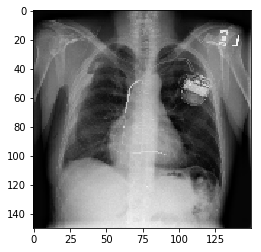

In [57]:
img_width = 150
img_height = 150
img_num = 79

img = image.load_img(f"images/{df['Image Index'][img_num]}", target_size=(img_width, img_height, 3))
plt.imshow(img)
img = image.img_to_array(img)
img = img/255.0
img = img.reshape(1, img_width, img_height, 3)
img = img[:,:,:,1]
img = img.reshape(1,150,150,1)

classes = list(df.columns[1:])
y_prob = model.predict(img)[0]
top3 = np.argsort(y_prob)[:-4:-1]

for i in range(3):
    print(classes[top3[i]])

Negative for cardiomegaly


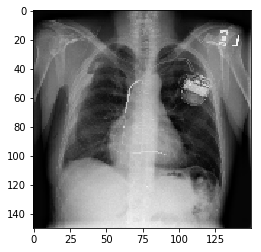

In [58]:
img = image.load_img(f"images/{df['Image Index'][img_num]}", target_size=(img_width, img_height, 3))
plt.imshow(img)
print('Negative for cardiomegaly')

In [38]:
results = []
for ind, cl in enumerate(classes):
    print(cl+f': {y_prob[ind]}')

Atelectasis: 0.0924997329711914
Cardiomegaly: 0.40119850635528564
Consolidation: 0.01846793293952942
Edema: 0.006468653678894043
Effusion: 0.08029663562774658
Emphysema: 0.00602683424949646
Fibrosis: 0.02208992838859558
Hernia: 0.005271315574645996
Infiltration: 0.15733729302883148
Mass: 0.03462021052837372
No Finding: 0.5044469833374023
Nodule: 0.06609492748975754
Pleural_Thickening: 0.025017669424414635
Pneumonia: 0.014695587567985058
Pneumothorax: 0.011718147434294224


In [19]:
y_prob

array([[0.09249973, 0.4011985 , 0.01846793, 0.00646865, 0.08029664,
        0.00602683, 0.02208993, 0.00527132, 0.1573373 , 0.03462021,
        0.504447  , 0.06609493, 0.02501767, 0.01469559, 0.01171815]],
      dtype=float32)

In [ ]:
training_data.append([img_name, avg_array, class_num])

In [ ]:
image_df = pd.DataFrame(self.TrainingArray())
        image_df = image_df.rename(columns={0: "img_name", 1: "avg_array", 2: "class_num"})

In [ ]:
results = []
for ind, cl in enumerate(classes):
    

In [72]:
actual = data.iloc[img_num,1:]

In [40]:
pred = y_prob

In [56]:
pd.DataFrame(actual)

0
Image Index         00000001_000.png
Atelectasis                        0
Cardiomegaly                       1
Consolidation                      0
Edema                              0
Effusion                           0
Emphysema                          0
Fibrosis                           0
Hernia                             0
Infiltration                       0
Mass                               0
No Finding                         0
Nodule                             0
Pleural_Thickening                 0
Pneumonia                          0
Pneumothorax                       0

In [44]:
pred

array([0.09249973, 0.4011985 , 0.01846793, 0.00646865, 0.08029664,
       0.00602683, 0.02208993, 0.00527132, 0.1573373 , 0.03462021,
       0.504447  , 0.06609493, 0.02501767, 0.01469559, 0.01171815],
      dtype=float32)

In [76]:
actual = data.iloc[0,1:].to_frame().rename(columns = {0:'Actual'})

In [77]:
actual

Actual
Atelectasis             0
Cardiomegaly            1
Consolidation           0
Edema                   0
Effusion                0
Emphysema               0
Fibrosis                0
Hernia                  0
Infiltration            0
Mass                    0
No Finding              0
Nodule                  0
Pleural_Thickening      0
Pneumonia               0
Pneumothorax            0

In [78]:
actual['Predicted'] = pred

In [79]:
actual

Actual  Predicted
Atelectasis             0   0.092500
Cardiomegaly            1   0.401199
Consolidation           0   0.018468
Edema                   0   0.006469
Effusion                0   0.080297
Emphysema               0   0.006027
Fibrosis                0   0.022090
Hernia                  0   0.005271
Infiltration            0   0.157337
Mass                    0   0.034620
No Finding              0   0.504447
Nodule                  0   0.066095
Pleural_Thickening      0   0.025018
Pneumonia               0   0.014696
Pneumothorax            0   0.011718

## Combining into one cell to produce a predict compatison function

In [97]:
def diagnosis(img_num = 0):
    img_width = 150
    img_height = 150
    img = image.load_img(f"images/{data['Image Index'][img_num]}", target_size=(img_width, img_height, 3))
    #plt.imshow(img)
    img = image.img_to_array(img)
    img = img/255.0
    img = img.reshape(1, img_width, img_height, 3)
    img = img[:,:,:,1]
    img = img.reshape(1,150,150,1)

    classes = list(data.columns[1:])
    pred = model.predict(img)[0]

    actual = data.iloc[img_num,1:].to_frame().rename(columns = {0:'Actual'})
    actual['Predicted'] = pred
    return actual

In [105]:
for num in range(100):
    print(diagnosis(num).sort_values('Predicted', ascending=False))

                   Actual  Predicted
No Finding              0   0.504447
Cardiomegaly            1   0.401199
Infiltration            0   0.157337
Atelectasis             0   0.092500
Effusion                0   0.080297
Nodule                  0   0.066095
Mass                    0   0.034620
Pleural_Thickening      0   0.025018
Fibrosis                0   0.022090
Consolidation           0   0.018468
Pneumonia               0   0.014696
Pneumothorax            0   0.011718
Edema                   0   0.006469
Emphysema               0   0.006027
Hernia                  0   0.005271
                    1  Predicted
No Finding          0   0.517817
Cardiomegaly        1   0.356140
Infiltration        0   0.154748
Atelectasis         0   0.104082
Effusion            0   0.087217
Nodule              0   0.054407
Mass                0   0.029302
Pleural_Thickening  0   0.022175
Consolidation       0   0.020429
Fibrosis            0   0.018677
Pneumonia           0   0.014724
Pneumothorax

In [ ]:
#test

In [4]:
def plot_learningCurve(history, epoch):
    # Plot training & validation accuracy values
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, history.history['acc'])
    plt.plot(epoch_range, history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [5]:
plot_learningCurve(history, 15)


NameError: name 'history' is not defined

In [11]:
img_width = 150
img_height = 150

(1, 150, 150, 3)
(1, 150, 150)
(1, 150, 150, 1)
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Cardiomegaly
No Finding
Infiltration


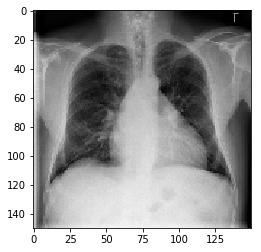

In [23]:
img = image.load_img('images/00000001_000.png', target_size=(img_width, img_height, 3))
plt.imshow(img)
img = image.img_to_array(img)
img = img/255.0

img = img.reshape(1, img_width, img_height, 3)

print(img.shape)
img = img[:,:,:,1]
print(img.shape)
img = img.reshape(1,150,150,1)
print(img.shape)

classes = list(data.columns[1:])
print(classes)
y_prob = model.predict(img)
top3 = np.argsort(y_prob[0])[:-4:-1]

for i in range(3):
    print(classes[top3[i]])

In [24]:
def predictor(image_name='00000001_000.png'):
    img = image.load_img(f'images/{image_name}', target_size=(img_width, img_height, 3))
    plt.imshow(img)
    img = image.img_to_array(img)
    img = img/255.0

    img = img.reshape(1, img_width, img_height, 3)

    img = img[:,:,:,1]
    img = img.reshape(1,150,150,1)

    classes = list(data.columns[1:])

    y_prob = model.predict(img)
    top3 = np.argsort(y_prob[0])[:-4:-1]

    for i in range(3):
        print(classes[top3[i]])

(1, 150, 150, 3)
(1, 150, 150)
(1, 150, 150, 1)
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Cardiomegaly
No Finding
Infiltration


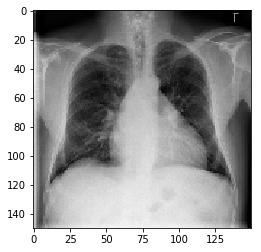

In [26]:
predictor()

[ 1 10  8]


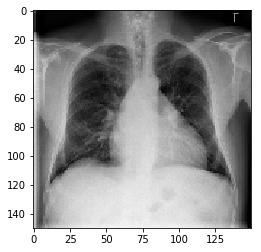

In [48]:
img = image.load_img('images/00000001_000.png', target_size=(img_width, img_height, 3))
plt.imshow(img)
img = image.img_to_array(img)
img = img/255.0

img = img.reshape(1, img_width, img_height, 3)
img = img[:,:,:,1]
img = img.reshape(1,150,150,1)

classes = list(data.columns[1:])
y_prob = model.predict(img)
diagnosis = np.argsort(y_prob[0])[:-4:-1]

# for i in range(3):
#     print(f'#{i+1}:' + classes[top3[i]])

print(diagnosis)

In [ ]:
for ind, cond in enumerate(classes):
    if y_prob[ind] > .5:
        print(f')

y_prob[0]

In [55]:
!mkdir pickle

In [58]:
pickle.dump(model, open('pickle/model_1.p', 'wb'))

TypeError: can't pickle _thread._local objects

In [57]:
history

In [ ]:
#!pip install tqdm

In [ ]:
# !jupyter nbextension enable --py widgetsnbextension

In [ ]:
# %%capture
# from tqdm import tqdm_notebook as tqdm
# tqdm().pandas()

In [2]:
# from tqdm.notebook import trange, tqdm
import time
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image


In [2]:
data = pd.read_csv('https://rads-reader-images.s3.us-east-2.amazonaws.com/Image_Dateframe.csv', index_col = 0)

In [3]:
data.shape

(112120, 16)

In [4]:
start_time = time.clock()
checkpoint = -1
sec_counter = [0]

img_width = 150
img_height = 150

range_num = data.shape[0]

X = []

for i in range(range_num):
    path = 'images/' + data['Image Index'][i]
    img = image.load_img(path,target_size=(img_width,img_height, 1))
    img = image.img_to_array(img)
    img = img/255
    X.append(img)
    
    if i % (range_num/10) == 0: 
        checkpoint += 1
        seconds = time.clock() - start_time
        sec_counter.append(seconds)
        print(f'checkpoint, {(i/range_num)*100}% complete. {seconds} seconds so far')
        sec_diff = sec_counter[-1] - sec_counter[-2]
        print(f'{sec_diff * (10-checkpoint)} remaining')
    
X = np.array(X)

pickle.dump( X, open( "save.p", "wb" ) )

checkpoint, 0.0% complete. 0.020000000000000018 seconds so far
0.20000000000000018 remaining
checkpoint, 10.0% complete. 136.63 seconds so far
1229.4899999999998 remaining
checkpoint, 20.0% complete. 279.13 seconds so far
1140.0 remaining
checkpoint, 30.0% complete. 424.65 seconds so far
1018.6399999999999 remaining
checkpoint, 40.0% complete. 559.36 seconds so far
808.2600000000002 remaining
checkpoint, 50.0% complete. 687.37 seconds so far
640.05 remaining
checkpoint, 60.0% complete. 814.99 seconds so far
510.48 remaining
checkpoint, 70.0% complete. 942.5 seconds so far
382.53 remaining
checkpoint, 80.0% complete. 1071.36 seconds so far
257.7199999999998 remaining
checkpoint, 90.0% complete. 1201.9399999999998 seconds so far
130.57999999999993 remaining


OverflowError: cannot serialize a bytes object larger than 4 GiB

In [48]:
X = X[:,:,:,0]

In [49]:
pickle.dump( X, open( "save.p", "wb" ), protocol=4)

In [50]:
X.shape

(112120, 150, 150)

In [10]:
### Load the training array

In [11]:
start_time = time.clock()

# import pickle

X = pickle.load( open( "save.p", "rb" ) )

time_elapsed = time.clock() - start_time
print(time_elapsed)

34.36999999999989


In [ ]:
import matplotlib.pyplot as plt
import cv2

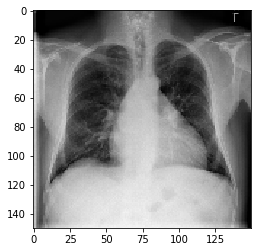

In [51]:
# img_name='00000001_000.png':
# img_array=cv2.imread('images/'+img_name)
plt.imshow(X[0],cmap="gray")
plt.show()

In [24]:
avg_array = []

for num in X:
    for nums in num:
        avg_array.append(np.mean(nums))
        
X_ = np.array(avg_array)

In [26]:
training_data = []
for img_name in self.ClassificationDf()['Image Index'][:n_images]:
    class_num = self.IndexedDf().loc[img_name]['cardiomegaly']
    img_array=cv2.imread('images/'+img_name) #creating image array
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    avg_array = []
    for num in new_array:
        for nums in num:
            avg_array.append(np.mean(nums))
    training_data.append([img_name, avg_array, class_num])

(16818000,)

In [43]:
X[0]

array([[[0.7372549 , 0.7372549 , 0.7372549 ],
        [0.6745098 , 0.6745098 , 0.6745098 ],
        [0.3764706 , 0.3764706 , 0.3764706 ],
        ...,
        [0.01568628, 0.01568628, 0.01568628],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784]],

       [[0.6666667 , 0.6666667 , 0.6666667 ],
        [0.3019608 , 0.3019608 , 0.3019608 ],
        [0.03921569, 0.03921569, 0.03921569],
        ...,
        [0.01568628, 0.01568628, 0.01568628],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784]],

       [[0.5411765 , 0.5411765 , 0.5411765 ],
        [0.18039216, 0.18039216, 0.18039216],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.01568628, 0.01568628, 0.01568628],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784]],

       ...,

       [[0.98039216, 0.98039216, 0.98039216],
        [0.73333335, 0.73333335, 0.73333335],
        [0.5019608 , 0

In [37]:
X_.shape

(112120, 150, 150, 3)

In [39]:
X[0].shape

(150, 150, 3)

In [41]:
x_0 = np.mean(X[0], axis=2)

In [46]:
x_j = X[:,:,:,0]

In [47]:
x_j.shape

(112120, 150, 150)

In [ ]:
start_time = time.clock()
checkpoint = -1
sec_counter = [0]

img_width = 150
img_height = 150

range_num = data.shape[0]

X = []

for i in range(range_num):
    path = 'images/' + data['Image Index'][i]
    img = image.load_img(path,target_size=(img_width,img_height, 1))
    img = image.img_to_array(img)
    img = img/255
    X.append(img)
    
    if i % (range_num/10) == 0: 
        checkpoint += 1
        seconds = time.clock() - start_time
        sec_counter.append(seconds)
        print(f'checkpoint, {(i/range_num)*100}% complete. {seconds} seconds so far')
        sec_diff = sec_counter[-1] - sec_counter[-2]
        print(f'{sec_diff * (10-checkpoint)} remaining')
    
X = np.array(X)

pickle.dump( X, open( "save.p", "wb" ) )

In [ ]:
img_width = 150
img_height = 150

X = []

for i in tqdm(range(data.shape[0])):
    path = 'images/' + data['Image Index'][i]
    img = image.load_img(path,target_size=(img_width,img_height, 1))
    img = image.img_to_array(img)
    img = img/255
    X.append(img)
    
X = np.array(X)

In [118]:
    path = 'images/' + data['Image Index'][i]
    img = image.load_img(path,target_size=(img_width,img_height, 1))
    img = image.img_to_array(img)
    img = img/255
    X.append(img)
    X = np.array(X)

In [119]:
X.shape

(3, 3, 350, 350)

In [120]:
X

array([[[[0.76862746, 0.7529412 , 0.7372549 , ..., 0.01960784,
          0.01960784, 0.00784314],
         [0.7529412 , 0.7176471 , 0.7058824 , ..., 0.01960784,
          0.01960784, 0.00784314],
         [0.7294118 , 0.7019608 , 0.6392157 , ..., 0.01960784,
          0.01960784, 0.00784314],
         ...,
         [0.99607843, 0.9843137 , 0.88235295, ..., 0.        ,
          0.        , 0.        ],
         [1.        , 0.972549  , 0.89411765, ..., 0.        ,
          0.        , 0.        ],
         [1.        , 0.9882353 , 0.88235295, ..., 0.        ,
          0.        , 0.        ]],

        [[0.76862746, 0.7529412 , 0.7372549 , ..., 0.01960784,
          0.01960784, 0.00784314],
         [0.7529412 , 0.7176471 , 0.7058824 , ..., 0.01960784,
          0.01960784, 0.00784314],
         [0.7294118 , 0.7019608 , 0.6392157 , ..., 0.01960784,
          0.01960784, 0.00784314],
         ...,
         [0.99607843, 0.9843137 , 0.88235295, ..., 0.        ,
          0.        , 0. 

In [97]:
df['Image Index']

0         00000001_000.png
1         00000001_001.png
2         00000001_002.png
3         00000002_000.png
4         00000003_000.png
5         00000003_001.png
6         00000003_002.png
7         00000003_003.png
8         00000003_004.png
9         00000003_005.png
10        00000003_006.png
11        00000003_007.png
12        00000004_000.png
13        00000005_000.png
14        00000005_001.png
15        00000005_002.png
16        00000005_003.png
17        00000005_004.png
18        00000005_005.png
19        00000005_006.png
20        00000005_007.png
21        00000006_000.png
22        00000007_000.png
23        00000008_000.png
24        00000008_001.png
25        00000008_002.png
26        00000009_000.png
27        00000010_000.png
28        00000011_000.png
29        00000011_001.png
                ...       
112090    00030786_000.png
112091    00030786_001.png
112092    00030786_002.png
112093    00030786_003.png
112094    00030786_004.png
112095    00030786_005.png
1

In [96]:
df['Image Index']['00000001_000.png']

KeyError: '00000001_000.png'

In [58]:
import pandas as pd

In [88]:
df = pd.read_csv('https://rads-reader-images.s3.us-east-2.amazonaws.com/Image_Dateframe.csv', index_col = 0)

In [98]:
df.tail()

Image Index  Atelectasis  Cardiomegaly  Consolidation  Edema  \
112115  00030801_001.png            0             0              0      0   
112116  00030802_000.png            0             0              0      0   
112117  00030803_000.png            0             0              0      0   
112118  00030804_000.png            0             0              0      0   
112119  00030805_000.png            0             0              0      0   

        Effusion  Emphysema  Fibrosis  Hernia  Infiltration  Mass  No Finding  \
112115         0          0         0       0             0     1           0   
112116         0          0         0       0             0     0           1   
112117         0          0         0       0             0     0           1   
112118         0          0         0       0             0     0           1   
112119         0          0         0       0             0     0           1   

        Nodule  Pleural_Thickening  Pneumonia  Pneumothorax  
112115       0                   0          1             0  
112116       0                   0          0             0  
112117       0                   0          0             0  
112118       0                   0          0             0  
112119       0                   0          0             0

In [90]:
df.columns

Index(['Image Index', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
       'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'],
      dtype='object')

In [66]:
conditions = ['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [69]:
# import pandas as pd
# import shutil

# Creating directories for all classes

# df = pd.read_csv('https://rads-reader-images.s3.us-east-2.amazonaws.com/Image_Dateframe.csv', index_col = 0)

# conditions = ['Atelectasis',
#  'Cardiomegaly',
#  'Consolidation',
#  'Edema',
#  'Effusion',
#  'Emphysema',
#  'Fibrosis',
#  'Hernia',
#  'Infiltration',
#  'Mass',
#  'No Finding',
#  'Nodule',
#  'Pleural_Thickening',
#  'Pneumonia',
#  'Pneumothorax']

# import os

# root_path = '/home/ec2-user/SageMaker/x-ray-disease-classification'
# folders = conditions
# for folder in folders:
#     os.mkdir(os.path.join(root_path,folder))



In [78]:
import shutil

In [71]:
shutil.copy('/home/ec2-user/SageMaker/x-ray-disease-classification/images/00000001_000.png', 
            '/home/ec2-user/SageMaker/x-ray-disease-classification/data/Cardiomegaly/')

'/home/ec2-user/SageMaker/x-ray-disease-classification/data/Cardiomegaly/00000001_000.png'

In [84]:
img = "00000002_000.png"
cond = "Cardiomegaly"

shutil.copy(f'/home/ec2-user/SageMaker/x-ray-disease-classification/images/{img}', 
            f'/home/ec2-user/SageMaker/x-ray-disease-classification/data/{cond}/')

'/home/ec2-user/SageMaker/x-ray-disease-classification/data/Cardiomegaly/00000002_000.png'

In [72]:
for ind in df.index[:5]:
    for col in df.columns:
        if df.iloc[ind][col] == 1:
            print(df.iloc[ind]['Image Index']+f': {col}')


00000001_000.png: Cardiomegaly
00000001_001.png: Cardiomegaly
00000001_001.png: Emphysema
00000001_002.png: Cardiomegaly
00000001_002.png: Effusion
00000002_000.png: No Finding
00000003_000.png: Hernia


In [86]:
for ind in df.index[:5]:
    img = df.iloc[ind]['Image Index']
    for col in df.columns:
        if df.iloc[ind][col] == 1:
            print(img + ': ' + col)
            shutil.copy(f'/home/ec2-user/SageMaker/x-ray-disease-classification/images/{img}', 
            f'/home/ec2-user/SageMaker/x-ray-disease-classification/data/{col}/')

00000001_000.png: Cardiomegaly
00000001_001.png: Cardiomegaly
00000001_001.png: Emphysema
00000001_002.png: Cardiomegaly
00000001_002.png: Effusion
00000002_000.png: No Finding
00000003_000.png: Hernia


In [92]:
# Commands to run in the terminal to copy files to their correct folders

# import pandas as pd
# import shutil
# import os

# Creating directories for all classes

# df = pd.read_csv('https://rads-reader-images.s3.us-east-2.amazonaws.com/Image_Dateframe.csv', index_col = 0)

# conditions = ['Atelectasis',
#  'Cardiomegaly',
#  'Consolidation',
#  'Edema',
#  'Effusion',
#  'Emphysema',
#  'Fibrosis',
#  'Hernia',
#  'Infiltration',
#  'Mass',
#  'No Finding',
#  'Nodule',
#  'Pleural_Thickening',
#  'Pneumonia',
#  'Pneumothorax']


# root_path = '/home/ec2-user/SageMaker/x-ray-disease-classification'
# folders = conditions
# for folder in folders:
#     os.mkdir(os.path.join(root_path,folder))


# for ind in df.index:
#     img = df.iloc[ind]['Image Index']
#     for col in df.columns:
#         if df.iloc[ind][col] == 1:
#             print(img + ': ' + col)
#             shutil.copy(f'/home/ec2-user/SageMaker/x-ray-disease-classification/images/{img}', 
#             f'/home/ec2-user/SageMaker/x-ray-disease-classification/data/{col}/')

In [35]:
import pandas as pd

In [36]:
labels = pd.read_csv("https://rads-reader.s3.us-east-2.amazonaws.com/data/categorical.csv")

In [87]:
labels.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN  
1                        0.143  0.143          NaN  
2                        0.168  0.168          NaN  
3                        0.171  0.171          NaN  
4                        0.143  0.143          NaN

In [37]:
images = labels['Image Index']

In [38]:
dummies = (labels['Finding Labels']).str.get_dummies()

In [39]:
dummies.columns

Index(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')

In [40]:
df = pd.concat([images,dummies], axis = 1)

In [41]:
df.head()

Image Index  Atelectasis  Cardiomegaly  Consolidation  Edema  \
0  00000001_000.png            0             1              0      0   
1  00000001_001.png            0             1              0      0   
2  00000001_002.png            0             1              0      0   
3  00000002_000.png            0             0              0      0   
4  00000003_000.png            0             0              0      0   

   Effusion  Emphysema  Fibrosis  Hernia  Infiltration  Mass  No Finding  \
0         0          0         0       0             0     0           0   
1         0          1         0       0             0     0           0   
2         1          0         0       0             0     0           0   
3         0          0         0       0             0     0           1   
4         0          0         0       1             0     0           0   

   Nodule  Pleural_Thickening  Pneumonia  Pneumothorax  
0       0                   0          0             0  
1       0                   0          0             0  
2       0                   0          0             0  
3       0                   0          0             0  
4       0                   0          0             0

In [42]:
df.to_csv('Image_Dateframe.csv')

In [43]:
df.head()

Image Index  Atelectasis  Cardiomegaly  Consolidation  Edema  \
0  00000001_000.png            0             1              0      0   
1  00000001_001.png            0             1              0      0   
2  00000001_002.png            0             1              0      0   
3  00000002_000.png            0             0              0      0   
4  00000003_000.png            0             0              0      0   

   Effusion  Emphysema  Fibrosis  Hernia  Infiltration  Mass  No Finding  \
0         0          0         0       0             0     0           0   
1         0          1         0       0             0     0           0   
2         1          0         0       0             0     0           0   
3         0          0         0       0             0     0           1   
4         0          0         0       1             0     0           0   

   Nodule  Pleural_Thickening  Pneumonia  Pneumothorax  
0       0                   0          0             0  
1       0                   0          0             0  
2       0                   0          0             0  
3       0                   0          0             0  
4       0                   0          0             0

In [44]:
df = pd.read_csv('Image_Dateframe.csv')

In [49]:
df = df.drop(columns=['Unnamed: 0'])

In [20]:
#Need to write a script to cp files conditionally 

In [ ]:
import os

root_path = '/whatever/your/root/path/is/'
folders = ['Folder_1','Folder_x','Folder_y']
for folder in folders:
    os.mkdir(os.path.join(root_path,folder))

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timeit

import tensorflow as tf
from tensorflow.keras import layers
keras = tf.keras
AUTOTUNE = tf.data.experimental.AUTOTUNE ## tf.data transformation parameters

matplotlib.style.use('ggplot')

In [2]:
labels = pd.read_csv("https://rads-reader.s3.us-east-2.amazonaws.com/data/categorical.csv")
conditions = ['Cardiomegaly','Emphysema','Effusion',
              'Hernia','No Finding','Infiltration',
              'Nodule','Mass','Pneumothorax','Atelectasis',
             'Pleural_Thickening','Fibrosis']
for condition in conditions:
    labels[condition] = [1 if condition in x else 0 for x in labels['Finding Labels']]
df = labels[['Image Index',
       'Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'No Finding',
       'Infiltration', 'Nodule', 'Mass', 'Pneumothorax', 'Atelectasis',
       'Pleural_Thickening', 'Fibrosis']]

In [3]:
df.head(1)

Image Index  Cardiomegaly  Emphysema  Effusion  Hernia  No Finding  \
0  00000001_000.png             1          0         0       0           0   

   Infiltration  Nodule  Mass  Pneumothorax  Atelectasis  Pleural_Thickening  \
0             0       0     0             0            0                   0   

   Fibrosis  
0         0

In [4]:
indexed_w_all = df.set_index('Image Index')
indexed_w_all.head(1)

Cardiomegaly  Emphysema  Effusion  Hernia  No Finding  \
Image Index                                                               
00000001_000.png             1          0         0       0           0   

                  Infiltration  Nodule  Mass  Pneumothorax  Atelectasis  \
Image Index                                                               
00000001_000.png             0       0     0             0            0   

                  Pleural_Thickening  Fibrosis  
Image Index                                     
00000001_000.png                   0         0

In [8]:
indexed_w_all.head()

Cardiomegaly  Emphysema  Effusion  Hernia  No Finding  \
Image Index                                                               
00000001_000.png             1          0         0       0           0   
00000001_001.png             1          1         0       0           0   
00000001_002.png             1          0         1       0           0   
00000002_000.png             0          0         0       0           1   
00000003_000.png             0          0         0       1           0   

                  Infiltration  Nodule  Mass  Pneumothorax  Atelectasis  \
Image Index                                                               
00000001_000.png             0       0     0             0            0   
00000001_001.png             0       0     0             0            0   
00000001_002.png             0       0     0             0            0   
00000002_000.png             0       0     0             0            0   
00000003_000.png             0       0     0             0            0   

                  Pleural_Thickening  Fibrosis  
Image Index                                     
00000001_000.png                   0         0  
00000001_001.png                   0         0  
00000001_002.png                   0         0  
00000002_000.png                   0         0  
00000003_000.png                   0         0

In [24]:
for img_name in df['Image Index'][:5]:
    print(img_name)

00000001_000.png
00000001_001.png
00000001_002.png
00000002_000.png
00000003_000.png


In [23]:
import shutil  
# shutil.copyfile('/path/to/file', '/path/to/other/phile')

In [26]:
!pwd

/home/ec2-user/SageMaker/x-ray-disease-classification


In [27]:
shutil.copy('images/00000001_000.png', '/test_images')

PermissionError: [Errno 13] Permission denied: '/test_images'

In [21]:
for img_name in df['Image Index'][:15]:
    shutil.copy(f'images/{img_name}', f'/test_images/{img_name}')

FileNotFoundError: [Errno 2] No such file or directory: '/test_images/00000001_000.png'

In [11]:
!pwd

/home/ec2-user/SageMaker/x-ray-disease-classification


In [12]:
!mkdir test_images

In [15]:
!ls

cnn_tests.ipynb  rads_reader_ec2.py  smaple_training_data.csv
images		 rads_reader_s3.py   src.py
__pycache__	 README.md	     test_images


In [5]:
def HalfConditionDf( condition = 'Hernia', small_sample = False):

    if small_sample == False:
        
        nofinding_df = df[df['No Finding'] == 1]
        nofinding_df_len = nofinding_df.iloc[:sum(df[condition])]
        condition_df = df[df[condition] == 1]
        half_condition_df = pd.concat([nofinding_df_len, condition_df])
        half_condition_df = half_condition_df[['Image Index', condition]]
        half_condition_df = half_condition_df.sample(frac=1)
        indexed_w_all = df.set_index('Image Index')
        training_data= []
        for img_name in half_condition_df['Image Index']:
            condition_pos = indexed_w_all.loc[img_name][condition]
            img_array = imread(f'images/{img_name}', as_grey=True)
            new_array = rescale(img_array, 1/3, mode='reflect')
            hog_array = hog(
                            new_array, pixels_per_cell=(12, 12),
                            cells_per_block=(2,2),
                            orientations=8,
                            visualise=False,
                            block_norm='L2-Hys')
            training_data.append([img_name, hog_array, condition_pos])
        hog_df = pd.DataFrame(training_data)
        hog_df = hog_df.rename(columns={0: "img_name", 
                                        1: "hog_array", 
                                        2: condition})
        smol_df = hog_df.apply(pd.Series)
        matrix_df = hog_df.hog_array.apply(pd.Series)
        df_merged = pd.concat([smol_df, matrix_df], axis=1, sort=False)
        df_merged = df_merged.drop('hog_array', axis = 1)
        return df_merged

    else:
        
        nofinding_df = df[df['No Finding'] == 1]
        nofinding_df_len = nofinding_df.iloc[:small_sample]
        condition_df = df[df[condition] == 1].iloc[:small_sample]
        half_condition_df = pd.concat([nofinding_df_len, condition_df])
        half_condition_df = half_condition_df[['Image Index', condition]]
        half_condition_df = half_condition_df.sample(frac=1)
        indexed_w_all = df.set_index('Image Index')
        training_data= []
        for img_name in half_condition_df['Image Index']:
            condition_pos = indexed_w_all.loc[img_name][condition]
            img_array = imread(f'images/{img_name}', as_grey=True)
            new_array = rescale(img_array, 1/3, mode='reflect')
            hog_array= hog(
                new_array, pixels_per_cell=(12, 12),
                cells_per_block=(2,2),
                orientations=8,
                visualise=False,
                block_norm='L2-Hys')
            training_data.append([img_name, hog_array, condition_pos])
        hog_df = pd.DataFrame(training_data)
        hog_df = hog_df.rename(columns={0: "img_name", 
                                        1: "hog_array", 
                                        2: condition})
        smol_df = hog_df.apply(pd.Series)
        matrix_df = hog_df.hog_array.apply(pd.Series)
        df_merged = pd.concat([smol_df, matrix_df], axis=1, sort=False)
        df_merged = df_merged.drop('hog_array', axis = 1)
        return df_merged

In [6]:
smol_training = HalfConditionDf()

NameError: name 'imread' is not defined